In [253]:
import os

#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import copy

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

#if device.type == 'cuda':
#  print(torch.cuda.get_device_name(0))

cuda


In [78]:
class config:
  def __init__(self):
    #The training parameters
    self.num_epoch = 10000

    #Optimizer
    self.lr = 0.001

    #Dataset parameters
    self.no_col_plts = 200
    self.x0 = 0
    self.xf = torch.pi
    self.col_pts = torch.linspace(self.x0, self.xf, self.no_col_plts).view(-1,1).float()

    ##Model hyperparameters
    self.tb_dim = 64 #Trunk and branch output dimension
    self.nodes = 32 #Hidden layers for trunk and branch

    #self.model_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/deeponet_burgers_model.pt'
    #self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/checkpoint_burgers_deeponet'


cfg = config()

### Data Preparation

In [14]:
from scipy import spatial, interpolate
def exp_quadratic(xa, xb, length_scale):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * spatial.distance.cdist(xa, xb, 'sqeuclidean') / length_scale**2
 
    return np.exp(sq_norm)

In [16]:
def gaussian_process(x, num_points, num_curves, length_scale_list, u_mean=0.):
    '''
    x -  tuple or list of upoer and lower limits [x0, x1]
    num_points - Number points in each curve (number of of features)
    num_curves - Number of curves to sample (number of samples)
    
    '''
    x0, x1 = x

    X = np.expand_dims(np.linspace(x0, x1, num_points), 1)

    #length_scale_list = [0.02, 0.2, 2.0, 20]
   
    ys = []
    # Draw samples from the prior at our data points.
    # Assume a mean of 0 for simplicity
    for _ in range(num_curves):
        length_scale = np.random.choice(length_scale_list) # Length scale of kernel randomly drawn from a list
        cov = exp_quadratic(X, X, length_scale) # Kernel of data points
        yst = np.random.multivariate_normal( mean=u_mean * np.ones(num_points), cov=cov, size=1)
        if len(ys) == 0:
            ys = yst
        else:
            ys = np.vstack((ys, yst))

    #ys = tf.math.multiply(ys, ((X+x0)*(X+x1)).T)
    #if (np.max(np.abs(ys)) > 1):
    #    ys = np.divide(ys, np.reshape(np.max(np.abs(ys), 1), (-1,1)) )

    return ys

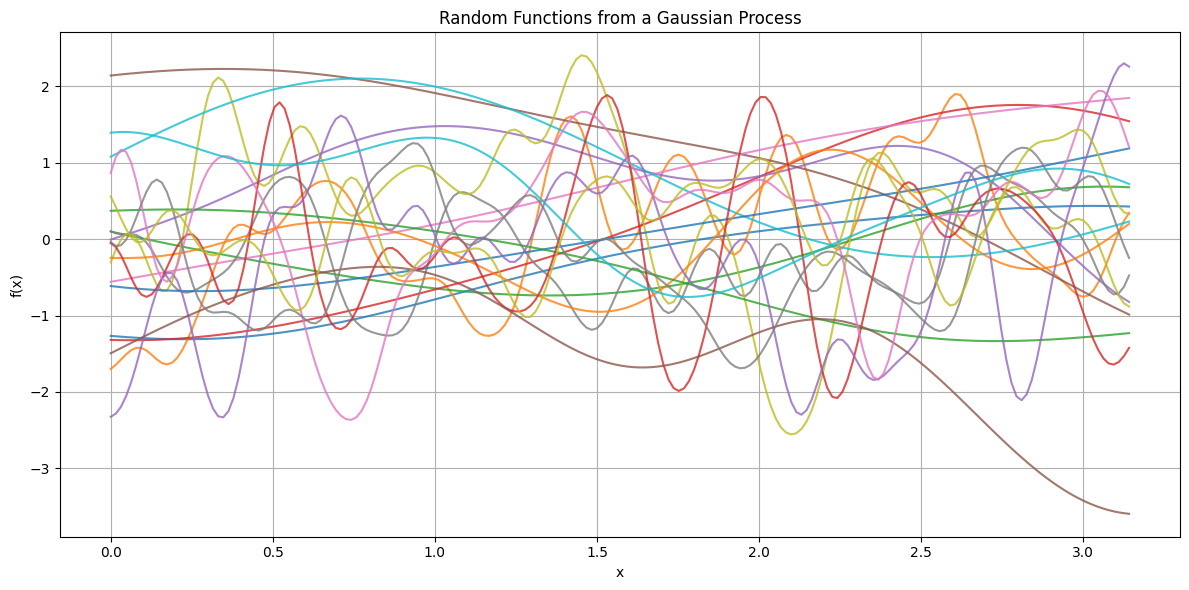

In [17]:
ys = gaussian_process(x=(0, np.pi), num_points=200, num_curves=20, length_scale_list=[0.1, 0.5, 1.0])
X = np.linspace(0, np.pi, 200)  # same num_points as above

plt.figure(figsize=(12, 6))
for i in range(ys.shape[0]):
    plt.plot(X, ys[i], label=f"Function {i+1}", alpha=0.8)

plt.title("Random Functions from a Gaussian Process")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.tight_layout()
plt.show()


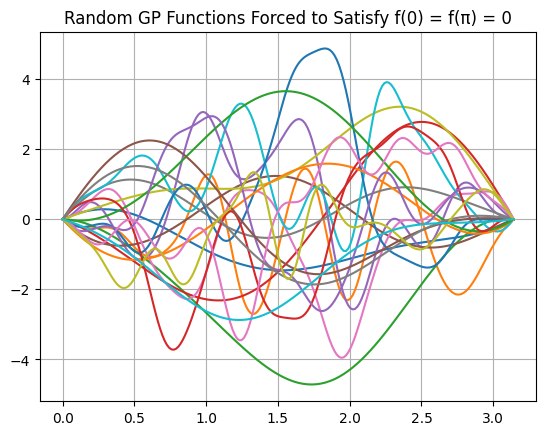

In [18]:
ys = gaussian_process((0, np.pi), 200, 20, [0.2, 1.0])  # your original function
X = np.linspace(0, np.pi, 200)
shape = X * (np.pi - X)  # vanishes at 0 and π

ys_bc = ys * shape  # apply boundary function

# Plot
for i in range(ys_bc.shape[0]):
    plt.plot(X, ys_bc[i])
plt.title("Random GP Functions Forced to Satisfy f(0) = f(π) = 0")
plt.grid()
plt.show()


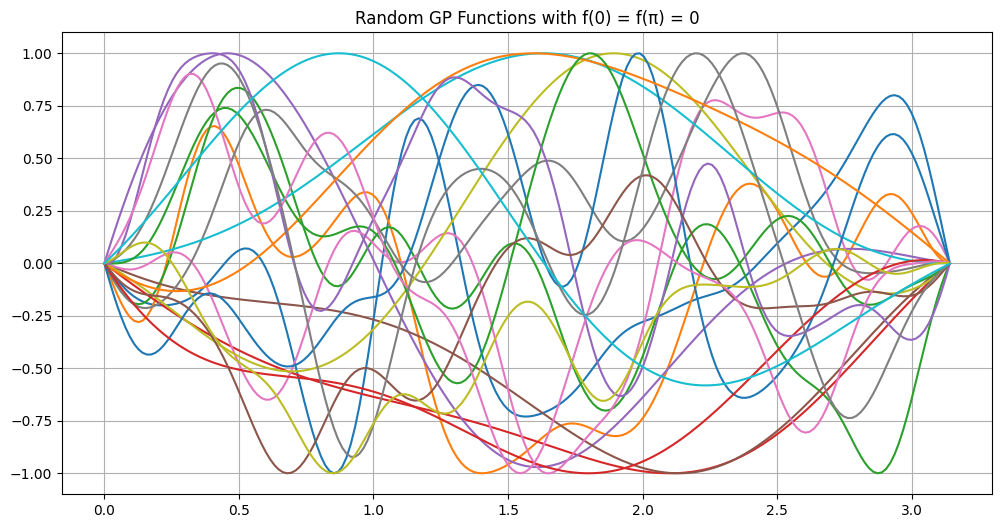

In [40]:
def exp_quadratic(xa, xb, length_scale):
    sqdist = np.sum(xa**2, 1).reshape(-1, 1) + np.sum(xb**2, 1) - 2 * np.dot(xa, xb.T)
    return np.exp(-0.5 * sqdist / length_scale**2)


def gaussian_process_with_boundary(x, num_points, num_curves, length_scale_list, u_mean=0.):
    x0, x1 = x
    X = np.expand_dims(np.linspace(x0, x1, num_points), 1)
    
    boundary_points = np.array([[x0], [x1]])  # f(x0) = 0, f(x1) = 0
    boundary_values = np.array([0.0, 0.0])     # The fixed values

    ys = []

    for _ in range(num_curves):
        length_scale = np.random.choice(length_scale_list)
        
        # Covariance matrices
        K_xx = exp_quadratic(X, X, length_scale)                  # Cov at all points
        K_xb = exp_quadratic(X, boundary_points, length_scale)    # Cov between X and boundary
        K_bb = exp_quadratic(boundary_points, boundary_points, length_scale)  # Cov at boundaries

        # Conditioning formula (GP posterior mean)
        K_bb_inv = np.linalg.inv(K_bb + 1e-6 * np.eye(2))  # add small jitter for numerical stability
        mean_cond = u_mean + K_xb @ K_bb_inv @ (boundary_values - u_mean)
        cov_cond = K_xx - K_xb @ K_bb_inv @ K_xb.T

        # Sample from the conditioned GP
        yst = np.random.multivariate_normal(mean_cond.flatten(), cov_cond)
        ys.append(yst)

    return np.vstack(ys)


init_data = gaussian_process_with_boundary((0, np.pi), num_points=200, num_curves=20, length_scale_list=[0.2, 1.0])
X = np.linspace(0, np.pi, 200)

plt.figure(figsize=(12, 6))
for i in range(init_data.shape[0]):
    plt.plot(X, init_data[i]/abs(init_data[i]).max())
plt.title("Random GP Functions with f(0) = f(π) = 0")
plt.grid()
plt.show()


### The Model

In [404]:
#first we define our NN module for
class NN(nn.Module):
    def __init__(self, cfg, layers , branch = True):
        super().__init__()
        self.activation = nn.Tanh()
        self.tb_dim = cfg.tb_dim
        self.hidden_dim = cfg.nodes
        self.branch_input = cfg.no_col_plts
        self.layers = layers #The number of layers

        #Defining the linear layers
        self.linears = nn.ModuleList()

        if branch:
            self.linears.append(nn.Linear(self.branch_input, self.hidden_dim)) #The first layer for the branch net
        else:
            self.linears.append(nn.Linear(3, self.hidden_dim)) #The first layer for the trunk net
        #Other layers
        for _ in range(self.layers - 2):
            self.linears.append(nn.Linear(self.hidden_dim, self.hidden_dim))
        self.linears.append(nn.Linear(self.hidden_dim, self.tb_dim)) #Output is (1024,tb_dim)

    def forward(self,x):
        a = x
        for linear in self.linears[:-1]:
            a = self.activation(linear(a))
        return self.linears[-1](a)

In [405]:
class DeepONet(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.branch = NN(cfg, layers= 3, branch= True) #branch net
        self.trunk = NN(cfg, layers= 2, branch= False) #trunk net

    def forward(self,b_in,t_in):
        """
        b_in: shape (eig_num, no_col_plts)
        t_in: shape (no_col_plts, 3)

        output: (eig_num, no_col_plts)
        """

        #The branch net: (eig_num, no_col_plts) --> (eig_num, tb_dim)
        B_out = self.branch(b_in)

        #The Trunk net: (no_col_plts, 3) --> (no_col_plts,tb_dim)
        T_out = self.trunk(t_in)

        #The inner product
        G = B_out @ T_out.T    #(eig_num, no_col_plts)

        return G

In [581]:
#Function to compute derivative
#def dfx(psi, x):
#    """
#    Computes the derivatives
#    psi: (eig_num, col_pts)
#    x = (col_pts)
#    """
#    dpsi_dx = []
#    for i in range(psi.shape[0]):  # loop over batch
#        grad_i = torch.autograd.grad(
#            outputs=psi[i],
#            inputs=x,
#            grad_outputs=torch.ones_like(psi[i]),
#            create_graph=True,
#        )[0]  # shape (col_pts,)
#        dpsi_dx.append(grad_i)
#
#    dpsi_dx = torch.stack(dpsi_dx)
#    return dpsi_dx


def central_diff(psi):
    """
    Compute the central difference for dpsi_dx
    
    psi: (eig_num, col_plts)

    """
    h = (cfg.xf - cfg.x0)/ cfg.no_col_plts
    dpsi_dx = torch.zeros_like(psi)

    # Central difference for interior points
    dpsi_dx[:, 1:-1] = (psi[:, 2:] - psi[:, :-2]) / (2 * h)

    # Forward difference at the first point
    dpsi_dx[:, 0] = (psi[:, 1] - psi[:, 0]) / h

    # Backward difference at the last point
    dpsi_dx[:, -1] = (psi[:, -1] - psi[:, -2]) / h

    return dpsi_dx

def d2fx_ctd(psi):
    """
    Compute second-order finite difference approximation

    psi: (eig_num, col_plts)
    """
    h = (cfg.xf - cfg.x0)/ cfg.no_col_plts
    psi_xx = torch.zeros_like(psi)

    # Central difference (2nd-order accurate)
    psi_xx[:, 1:-1] = (psi[:, 2:] - 2 * psi[:, 1:-1] + psi[:, :-2]) / (h ** 2)

    # A second order finite differencing at the boundaries
    psi_xx[:, 0] = (2*psi[:, 0] - 5* psi[:, 1] + 4*psi[:, 2] -psi[:,3]) / (h ** 2)

    psi_xx[:, -1] = (2*psi[:, -1] - 5* psi[:, -2] + 4*psi[:, -3] -psi[:,-4]) / (h ** 2)

    return psi_xx

In [643]:
A = torch.arange(1,17).view(4,4)
torch.triu(torch.ones_like(A), diagonal=0) * A

tensor([[ 1,  2,  3,  4],
        [ 0,  6,  7,  8],
        [ 0,  0, 11, 12],
        [ 0,  0,  0, 16]])

### Loss

In [644]:
#Orthogonality loss
def ortho_loss(psi):
    psi_norm = psi/torch.norm(psi, dim = 1, keepdim=True)
    cos_matr = psi_norm @ psi_norm.T
    off_diag = torch.triu(torch.ones_like(cos_matr), diagonal=0) * cos_matr
    loss = torch.sum(abs(off_diag))
    return loss

#The Physics loss
def res_loss(psi, x):
    psi_x = central_diff(psi) #Compute the derivative
    psi_xx = d2fx_ctd(psi)
    num = torch.trapz(psi_x**2, x, dim = 1)
    denom = torch.trapz(psi**2, x, dim = 1)
    E = num/denom #Compute eigenvalues
    res = psi_xx + E.unsqueeze(1)* psi #The residuals
    loss = F.mse_loss(res, torch.zeros_like(res))
    return loss, E

#The normality loss
def norm_loss(psi,x):
  psi_norm = torch.sqrt(torch.trapz(psi**2, x, dim=1))  # (k,)
  scale_term = (cfg.xf - cfg.x0)*psi_norm/cfg.no_col_plts
  return torch.sum((1-scale_term).pow(2))

In [645]:
def common_train_step(NN,b_in, t_in, x):
    #Forward pass
    psi = NN(b_in, t_in)
    #Loss after forward pass
    pde_loss, E = res_loss(psi,x)
    n_loss = norm_loss(psi,x)
    o_loss = ortho_loss(psi,x)
    t_loss = o_loss + n_loss + 10.0*pde_loss
    return t_loss,E

### Learning rate finder

In [647]:
x_col = torch.linspace(cfg.x0, cfg.xf, cfg.no_col_plts).float().to(device)

b_input = torch.tensor(init_data).float().to(device)
t_input = torch.stack([x_col, torch.sin(x_col), torch.cos(x_col)], dim=1)

print(f" Branch input: {b_input.shape}, Trunk input: {t_input.shape}" )

 Branch input: torch.Size([20, 200]), Trunk input: torch.Size([200, 3])


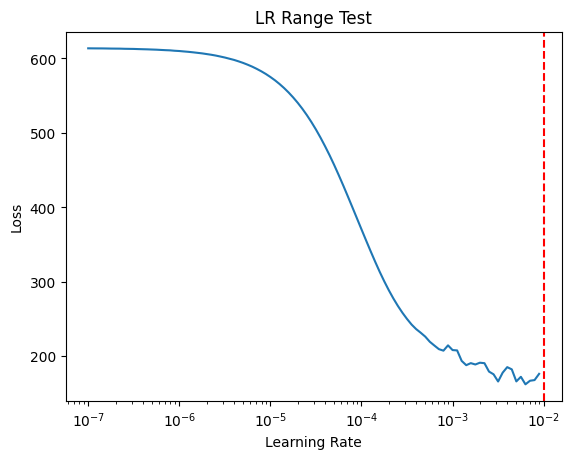

In [648]:
#We want to find the best lr for our defined model
model_lr = DeepONet(cfg).to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=1e-7)

def lr_range_test(NN, b_in, t_in, x):

    losses = []; lrs = []

    start_lr = 1e-7
    end_lr = 0.01
    num_iter = 100
    lr_mult = (end_lr / start_lr) ** (1/num_iter)

    lr = start_lr

    for iteration in range(num_iter):
        optimizer_lr.param_groups[0]['lr'] = lr

        optimizer_lr.zero_grad()

        #Forward pass
        psi = NN(b_in, t_in)
        pde_loss, _ = res_loss(psi, x)

        #Loss after forward pass

        #n_loss = norm_loss(psi,x)
        o_loss = ortho_loss(psi)
        t_loss = o_loss  + 1e4*pde_loss
        t_loss.backward()

        optimizer_lr.step()

        lrs.append(lr)
        losses.append(t_loss.item())

        lr *= lr_mult  # increase learning rate exponentially

    # Plot the result
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.axvline(x=0.01, color='red', linestyle='--')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('LR Range Test')
    plt.show()

lr_range_test(model_lr, b_input,t_input, x_col)

### Training

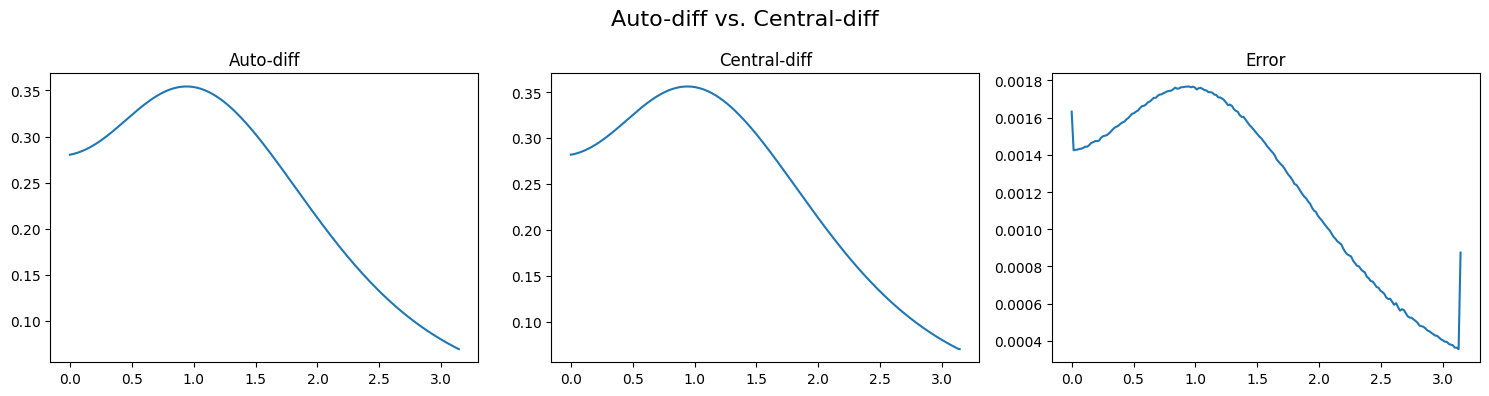

In [ ]:
#dpsi_dx1 = dfx(out, x_col).detach().cpu()
#
#dpsi_dx2 = central_diff(out).detach().cpu()
#
#x_plot = cfg.col_pts.squeeze(-1)
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
#fig.suptitle("Auto-diff vs. Central-diff", fontsize=16)
## Plot each function in its own subplot
#n = 15
#ax1.plot(x_plot, dpsi_dx1[n])
#ax1.set_title("Auto-diff")
#
#ax2.plot(x_plot, dpsi_dx2[n])
#ax2.set_title("Central-diff")
#
#diff = abs(dpsi_dx1 - dpsi_dx2)
#ax3.plot(x_plot, diff[n])
#ax3.set_title("Error")
#
#plt.tight_layout()
#plt.show()

In [649]:
model = DeepONet(cfg)
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(),lr = 1e-4)

DeepONet(
  (branch): NN(
    (activation): Tanh()
    (linears): ModuleList(
      (0): Linear(in_features=200, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (trunk): NN(
    (activation): Tanh()
    (linears): ModuleList(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
)


In [650]:
En_history = [] #To store the eigenvalues as it is optimized
loss_dic = {'pde_loss_hist': [], 'cos_loss_hist': [], 'norm_loss':[], 'total_loss_hist': []} #To store the losses

#Dictionary to store the final training
dic = {}

best_loss = 1e-4; best_iter = 0
stime = time.time()
for iter in range(cfg.num_epoch + 1):
    optimizer.zero_grad()
    #Forward pass
    psi = model(b_input, t_input)
    pde_loss, En = res_loss(psi, x_col)

    #Loss after forward pass
    #n_loss = norm_loss(psi,x_col)
    o_loss = ortho_loss(psi)/5
    total_loss = o_loss + 1e4*pde_loss

    total_loss.backward()    
    optimizer.step()


    En_history.append((En.clone().detach().cpu().numpy()))
#
    loss_dic['pde_loss_hist'].append(pde_loss.item())
    loss_dic['cos_loss_hist'].append(o_loss.item())
    #loss_dic['norm_loss'].append(n_loss.item())


    #Printing
    if iter % 200 == 0:
        print('--------------------------------------------')
        print(f'Epoch: {iter}')
        print(f'En: {En_history[-1][:10]}')
        print('--------------------------------------------')
        print('Total_loss: ',total_loss.item())
        print('pde_loss: ',1e4*pde_loss.item())
        #print('norm_loss: ',10*n_loss.item())
        print('cos_loss: ',o_loss.item())


    if total_loss.item() < best_loss:
        dic[0] = copy.deepcopy(model.state_dict())
        best_loss = total_loss.item()
        best_iter = iter

#storing the final solution
dic[1] = copy.deepcopy(model.state_dict())

ftime = time.time()
ttime = (ftime - stime)/60
print(f'Total training time is {ttime} minutes')
if best_iter == 0:
    print("Best loss is at final time")
else:
    print(f"Best loss is at epoch: {best_iter}")

--------------------------------------------
Epoch: 0
En: [0.05713956 0.5778766  0.6018445  0.41050372 0.43460578 0.42706743
 0.11808275 0.05189569 0.11643143 1.2440823 ]
--------------------------------------------
Total_loss:  386.55694580078125
pde_loss:  348.3843058347702
cos_loss:  38.17263412475586
--------------------------------------------
Epoch: 200
En: [0.13615733 1.7787813  0.16357976 0.14501989 0.11313291 0.19492586
 0.894796   0.09146243 0.12898043 1.0240695 ]
--------------------------------------------
Total_loss:  27.770933151245117
pde_loss:  1.9053540017921478
cos_loss:  25.86557960510254
--------------------------------------------
Epoch: 400
En: [0.1478736  1.710563   0.16662398 0.12642863 0.14560029 0.17288983
 0.9718282  0.11680704 0.10033232 0.95548093]
--------------------------------------------
Total_loss:  26.834245681762695
pde_loss:  1.253830996574834
cos_loss:  25.580413818359375
--------------------------------------------
Epoch: 600
En: [0.15578993 1.48

KeyboardInterrupt: 

In [652]:
En

tensor([0.0747, 1.0171, 0.0766, 0.0716, 0.0718, 0.0795, 1.0065, 0.0746, 0.0567,
        1.0116, 0.0744, 0.0819, 0.0761, 0.0772, 1.0134, 0.0754, 4.0090, 1.0065,
        0.0762, 1.0248], device='cuda:0', grad_fn=<DivBackward0>)

In [653]:
torch.set_printoptions(sci_mode=False)

a = torch.norm(psi, dim = 1, keepdim=True).float()
b = torch.sqrt(torch.trapz(psi**2, x_col, dim=1)).unsqueeze(1).float()

torch.cat([a,b], dim=1)

tensor([[2.5892, 0.3245],
        [1.5480, 0.1936],
        [1.9323, 0.2422],
        [4.4599, 0.5590],
        [1.1353, 0.1423],
        [2.8549, 0.3578],
        [2.1770, 0.2723],
        [1.0288, 0.1289],
        [3.8724, 0.4853],
        [1.2995, 0.1625],
        [1.6962, 0.2126],
        [1.7908, 0.2244],
        [4.7661, 0.5974],
        [3.2661, 0.4094],
        [1.8574, 0.2323],
        [6.5254, 0.8178],
        [0.5471, 0.0684],
        [2.5802, 0.3227],
        [5.8113, 0.7283],
        [0.5560, 0.0695]], device='cuda:0', grad_fn=<CatBackward0>)

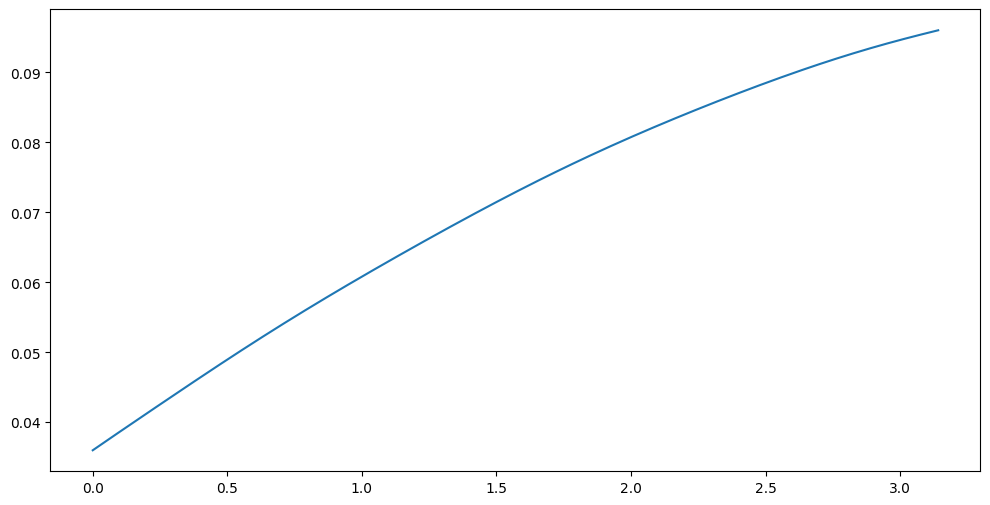

In [659]:
plt.figure(figsize=(12,6))
plt.plot(x_col.clone().detach().cpu(), psi[7].clone().detach().cpu())
plt.show()